## ** An Experimental Study on Performance of Non-intrusive Load Monitoring **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * NILM performance was evaluated in terms of precision, recall, accuracy, and F1 score, which are commonly used performance indicators for classification models, and whether the results satisfied the target level.
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.

In [6]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error

from work.benchmark.rnndisaggregator_fe import RNNDisaggregatorFE
from work.benchmark.grudisaggregator_fe import GRUDisaggregatorFE
from work.benchmark.windowgrudisaggregator_fe import WindowGRUDisaggregatorFE
from work.benchmark.daedisaggregator_fe import DAEDisaggregatorFE
from work.benchmark.shortseq2pointdisaggregator_fe import ShortSeq2PointDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

#### Configuration

In [7]:
###############################################################
# Common
###############################################################
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = 'data/enertalk.h5'

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-23'

HOME_ID = 1
appliances = ['television', 'washing machine', 'rice cooker', 'water filter', 'microwave']

In [8]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[HOME_ID].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[HOME_ID].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        
    return predicted

## Performance Comparison (binary relevance vs. chain classifier)

- Description
  However, the proposed method was implemented in the form of a regression model in NILMTK to be able to compare its performance with those 
  of other methods. Thus, it returns prediction results as a time-series of data, which had to then be converted into a classification 
  result. A successful prediction was defined as electricity being consumed by an appliance when it was predicted to be consumed and when 
  the predicted value was higher than a threshold of 10 watts. This threshold was used not to reflect false use, such as a device consuming 
  insignificant amounts of power in a standby state.

#### binary relevance

********************
[DRF-television]
********************


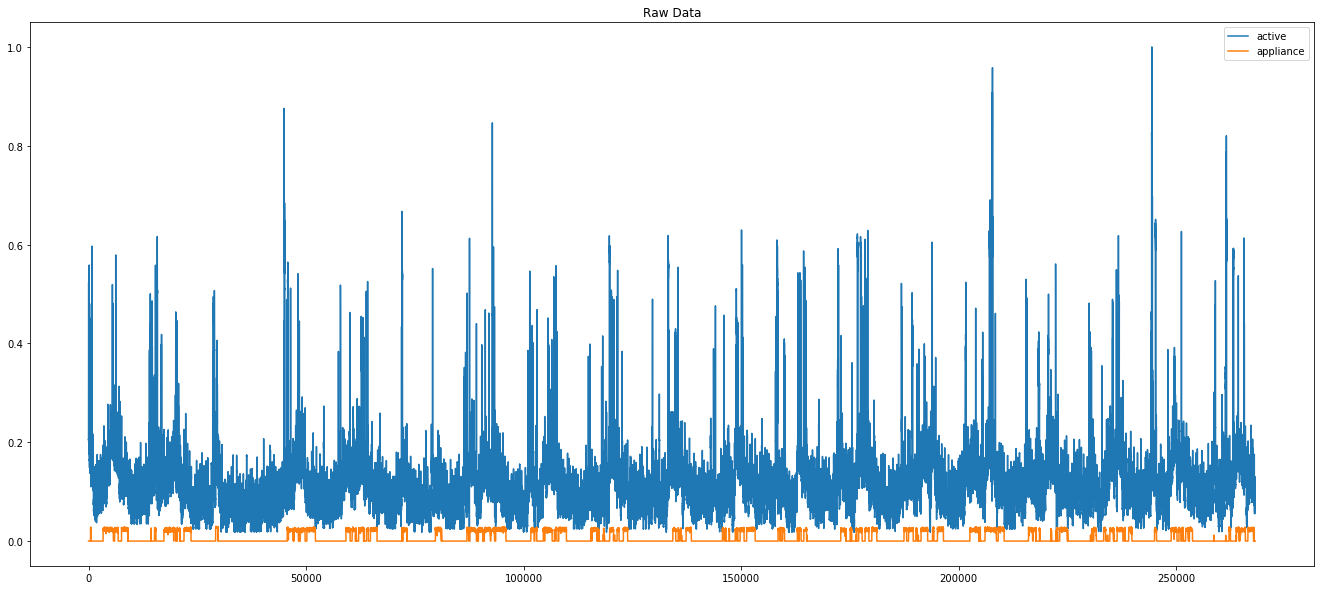

feature selection is done..
model fit is done..
min     0.247468
diff    0.129199
f5      0.060124
std     0.047071
max     0.040198
a9      0.031040
f6      0.028027
f4      0.027686
f7      0.026034
f3      0.025656
a0      0.024199
q0      0.023588
f8      0.023320
f2      0.023289
a1      0.022118
a8      0.022057
f9      0.021681
f1      0.021539
q1      0.020932
q2      0.019312
a2      0.017725
a7      0.017649
a3      0.016824
a6      0.016458
a4      0.016208
a5      0.014816
mean    0.008140
f0      0.007640
dtype: float64


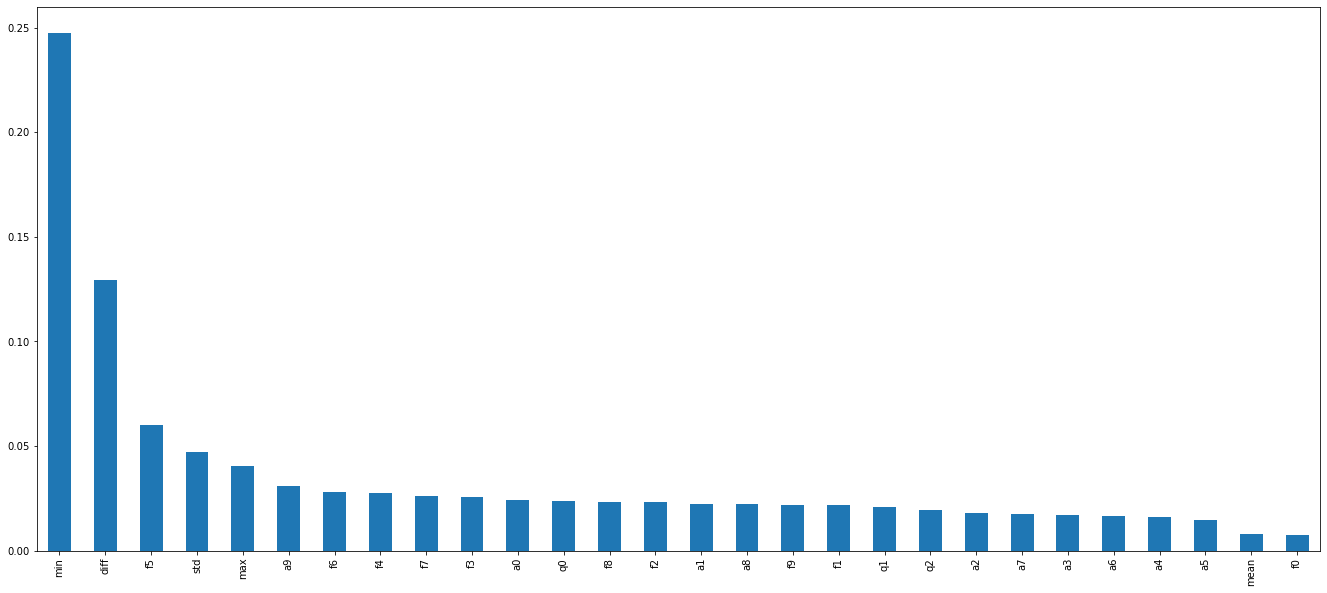

train on chunk is done..
elapsed time (secs) = 1225.776665687561
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.1302330216684056
============ Mean absolute error(in Watts): 32.051412637772884
============ Recall: 0.9551972715293389
============ Precision: 0.5514633491452609
============ Accuracy: 0.6319097222222222
============ F1 Score: 0.699236814480665
********************
[DRF-washing machine]
********************


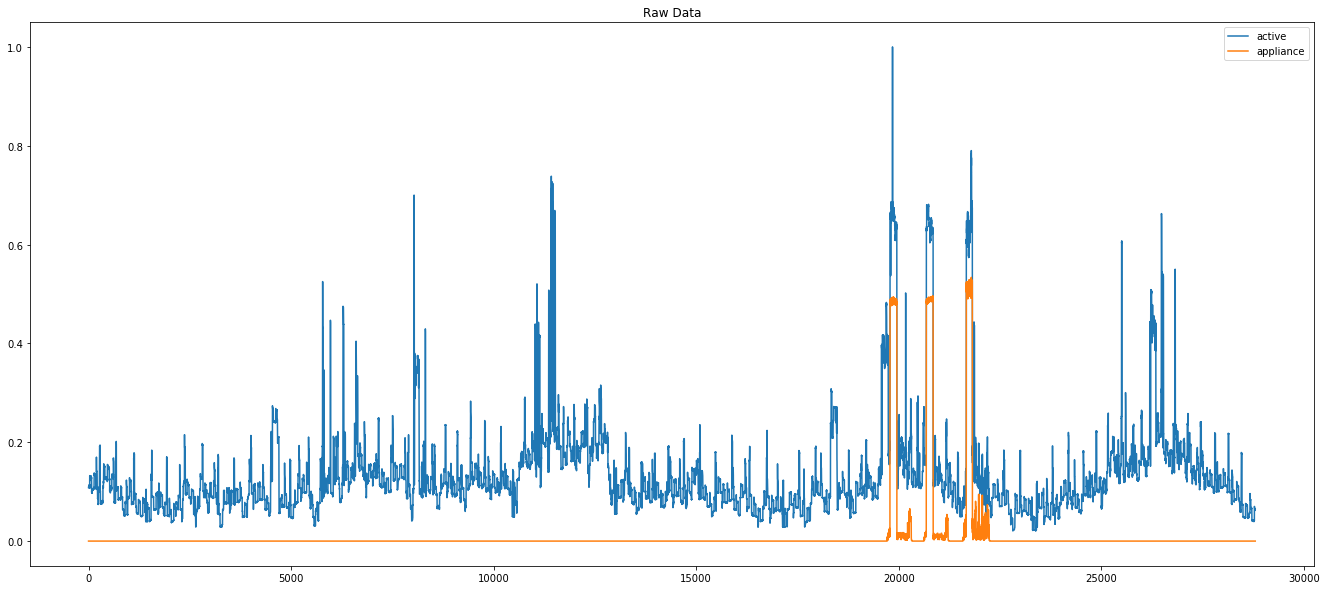

feature selection is done..
model fit is done..
min     0.873228
a9      0.025975
f5      0.020581
q0      0.019735
f0      0.010025
mean    0.009701
a0      0.007654
diff    0.006806
f3      0.003438
f7      0.003320
std     0.003148
max     0.002702
a1      0.001927
a8      0.001484
f9      0.001221
f1      0.001064
a6      0.000876
f4      0.000848
a4      0.000814
a2      0.000810
q2      0.000786
q1      0.000779
a7      0.000640
a3      0.000610
f6      0.000562
f2      0.000555
f8      0.000474
a5      0.000236
dtype: float64


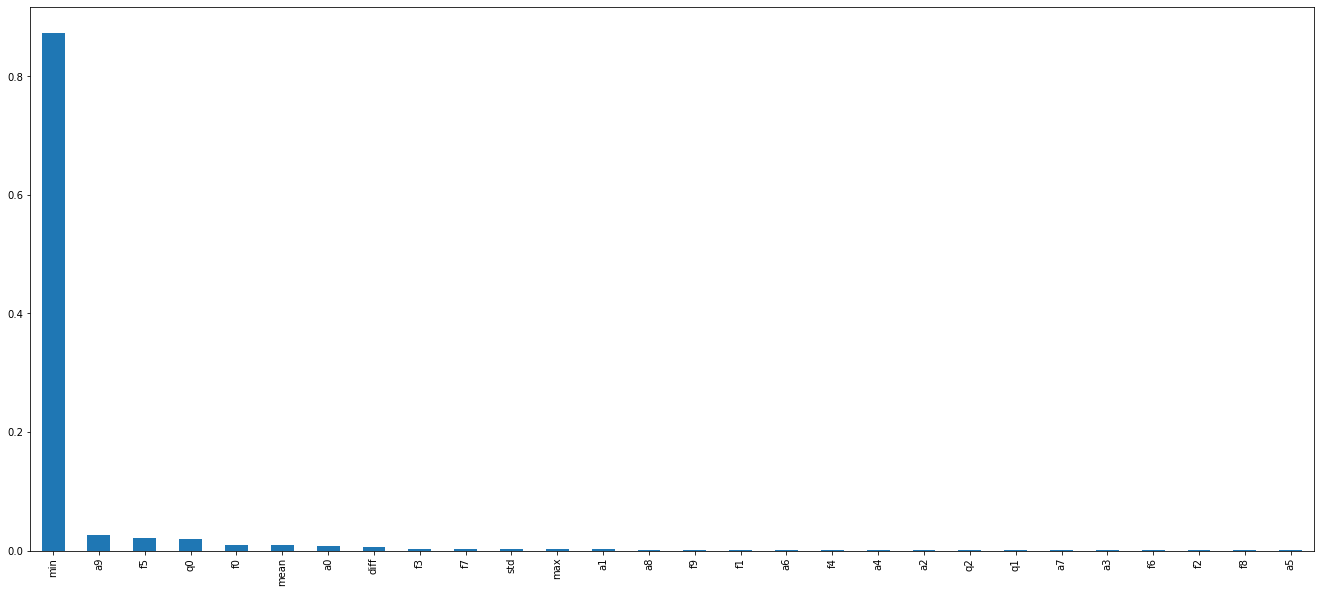

train on chunk is done..
elapsed time (secs) = 156.31846356391907
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.03162952306213759
============ Mean absolute error(in Watts): 2.862167180443977
============ Recall: 0.9283819628647215
============ Precision: 0.8536585365853658
============ Accuracy: 0.9848958333333333
============ F1 Score: 0.8894536213468869
********************
[DRF-rice cooker]
********************


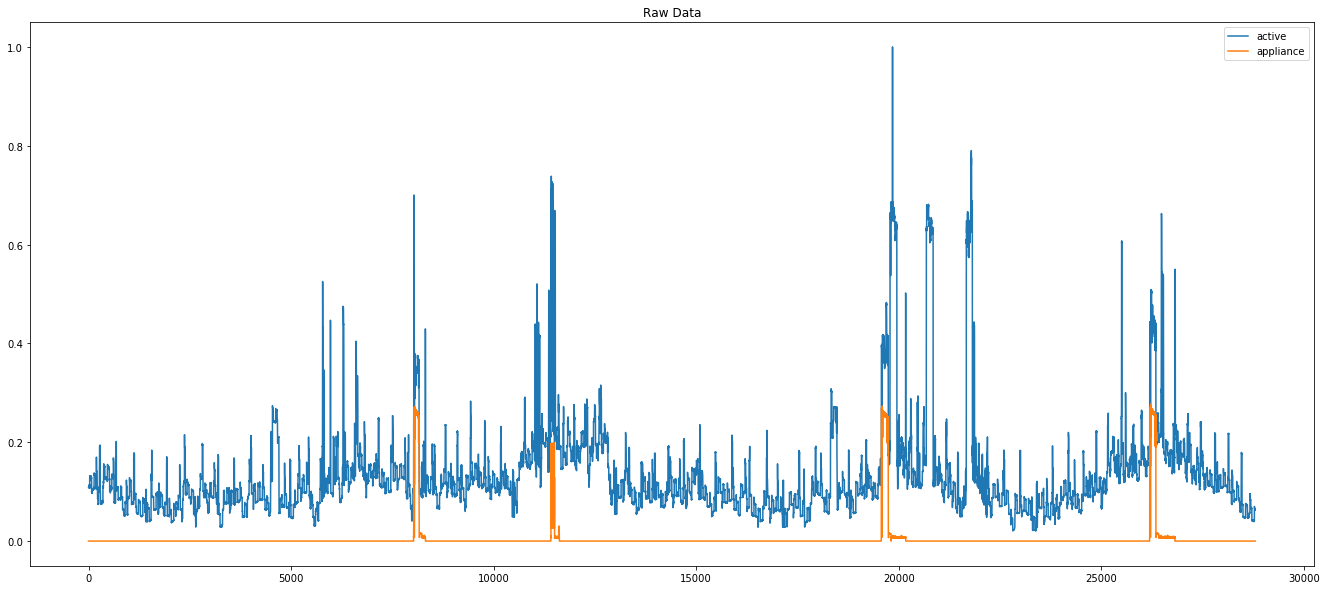

feature selection is done..
model fit is done..
a9      0.464465
max     0.258304
std     0.047248
diff    0.041096
a0      0.040416
min     0.032489
a1      0.017352
a8      0.013147
q1      0.011530
q2      0.009655
a7      0.007468
a5      0.005843
f5      0.005793
q0      0.004914
f4      0.004888
f7      0.004185
f3      0.004111
f6      0.004100
f1      0.003159
f9      0.003002
a2      0.002686
a3      0.002545
f2      0.002496
a6      0.002361
a4      0.002358
f8      0.002028
mean    0.001311
f0      0.001052
dtype: float64


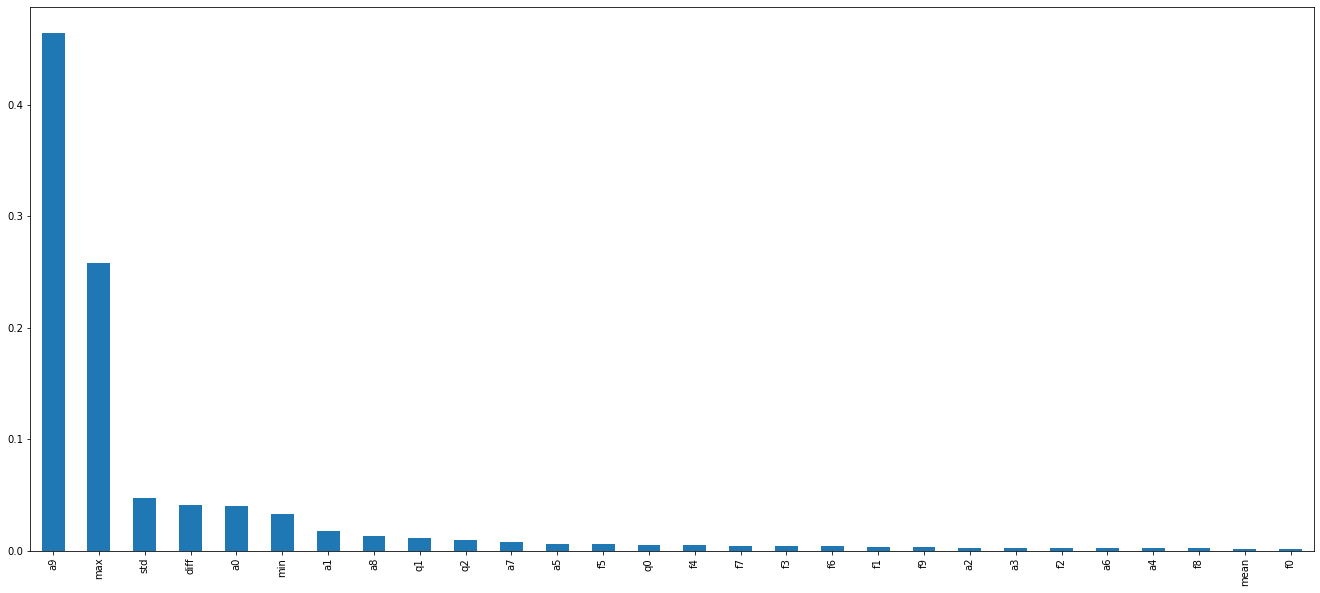

train on chunk is done..
elapsed time (secs) = 133.75755333900452
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.004079924596120019
============ Mean absolute error(in Watts): 1.529748767411117
============ Recall: 0.9389978213507625
============ Precision: 0.9016736401673641
============ Accuracy: 0.9895833333333334
============ F1 Score: 0.919957310565635
********************
[DRF-water filter]
********************


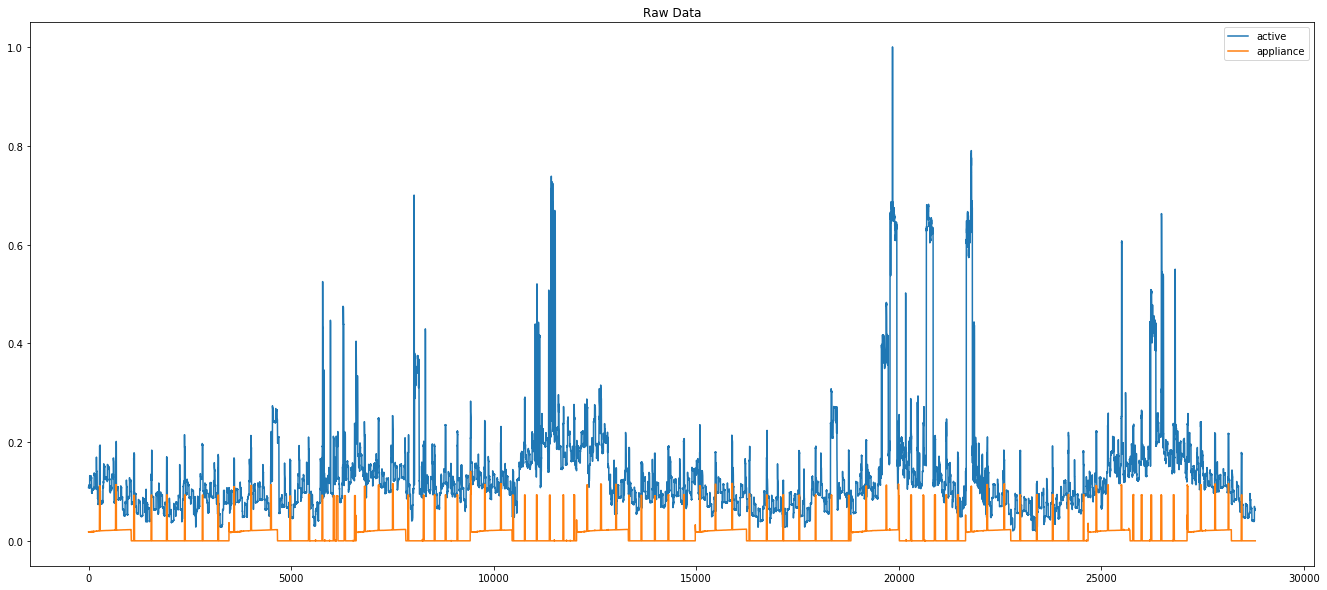

feature selection is done..
model fit is done..
a9      0.227743
diff    0.114944
a0      0.114072
max     0.085984
min     0.076039
std     0.039438
q0      0.034542
a8      0.027487
q2      0.027303
f5      0.023680
a1      0.023596
q1      0.017251
a7      0.015620
a2      0.014518
f6      0.013655
f4      0.012438
a3      0.012367
f1      0.012308
a6      0.011912
f7      0.011576
f3      0.011451
f9      0.011137
f2      0.010769
f8      0.010737
a4      0.010364
a5      0.010238
f0      0.009809
mean    0.009022
dtype: float64


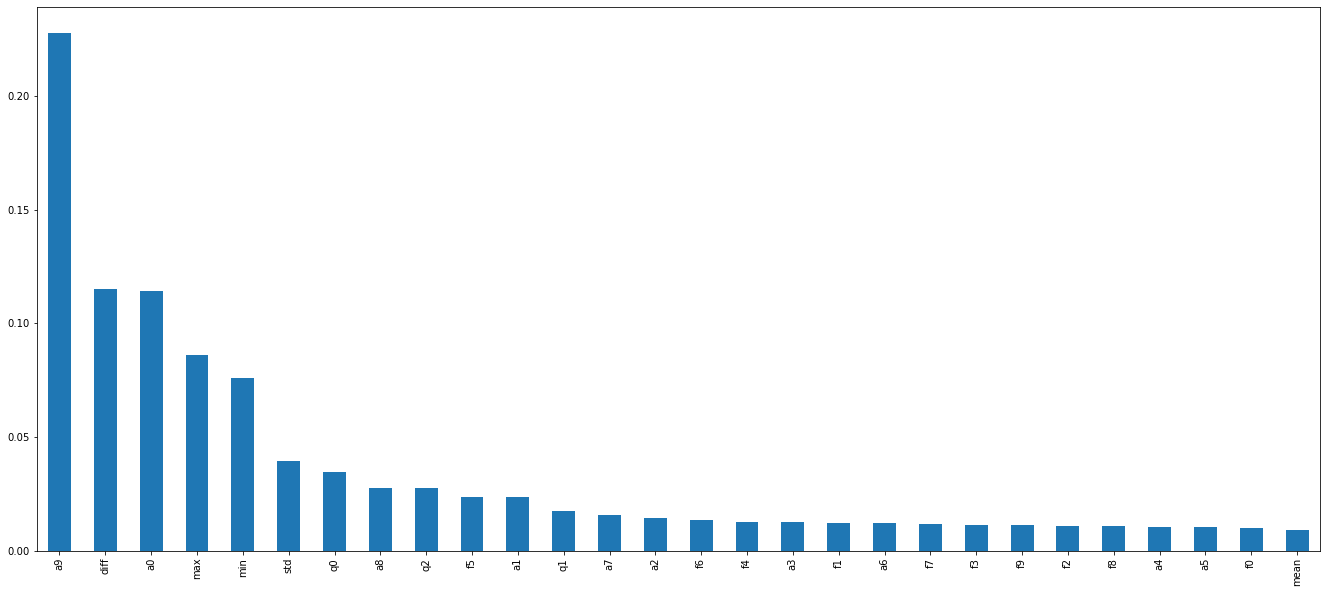

train on chunk is done..
elapsed time (secs) = 97.07391452789307
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.010174255515744877
============ Mean absolute error(in Watts): 10.322291806344133
============ Recall: 0.9968426868734707
============ Precision: 0.6660162430123405
============ Accuracy: 0.7787152777777778
============ F1 Score: 0.7985204388100281
********************
[DRF-microwave]
********************


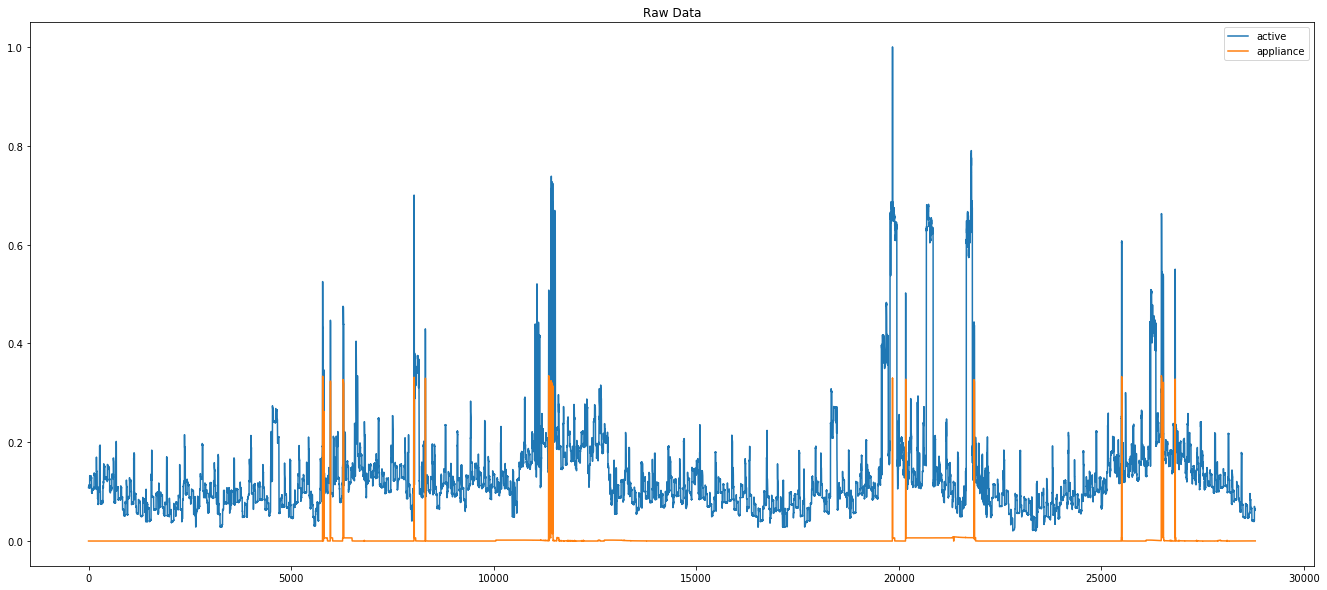

feature selection is done..
model fit is done..
diff    0.353191
a9      0.216508
std     0.064437
f5      0.047948
min     0.037133
max     0.031771
f4      0.027706
a8      0.023068
a1      0.019905
f6      0.019295
a6      0.018598
q0      0.018149
q1      0.015740
a7      0.011294
f8      0.010909
f3      0.010121
f9      0.009092
f2      0.008481
f1      0.008465
f7      0.008264
q2      0.007558
f0      0.006444
a0      0.006101
a3      0.005028
mean    0.004535
a2      0.003687
a5      0.003446
a4      0.003125
dtype: float64


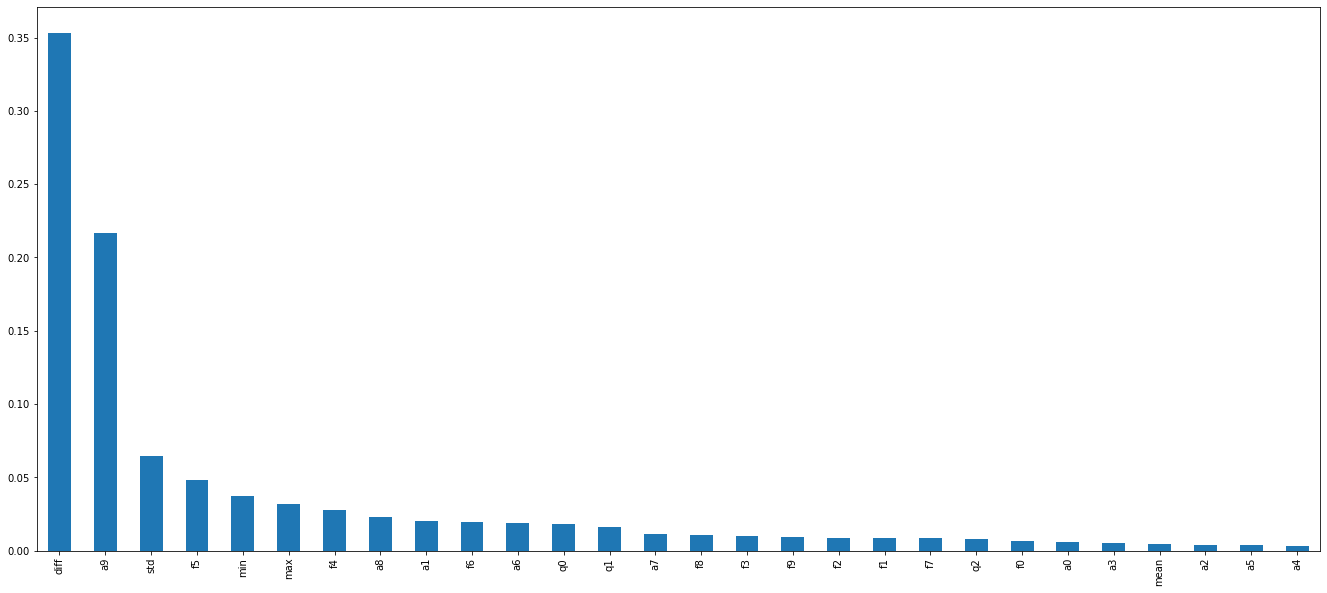

train on chunk is done..
elapsed time (secs) = 138.3719823360443
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.0031260458725107013
============ Mean absolute error(in Watts): 1.840529309873466
============ Recall: 0.951396861844623
============ Precision: 0.9370523935167735
============ Accuracy: 0.9897916666666666
============ F1 Score: 0.9441701481200152


In [11]:
T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-23'

dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

result = []

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            pred = disaggregate(dataset, model, aname, P_S, P_E, True)
            result.append(pred)
        
        except Exception as e:
            print('train & test error', e)
  

#### Chain classifier

********************
[DRF-microwave]
********************


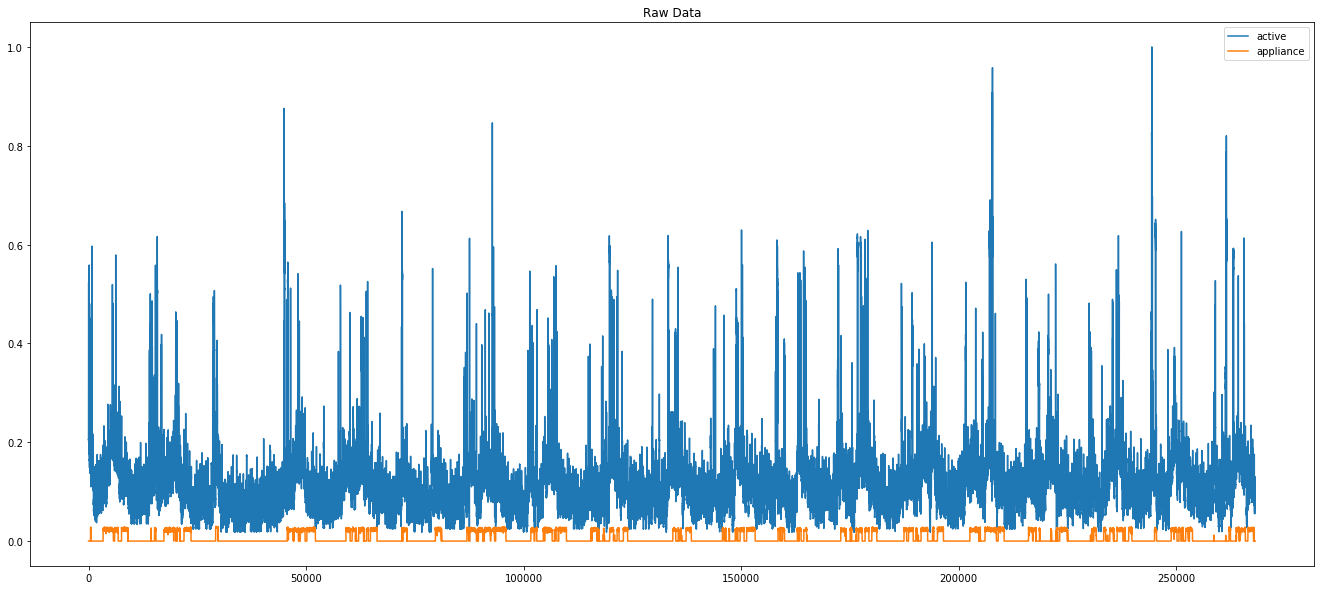

feature selection is done..
model fit is done..
min     0.247586
diff    0.129353
f5      0.060684
std     0.046963
max     0.040628
a9      0.030497
f6      0.028418
f4      0.027956
f7      0.025938
f3      0.025915
a0      0.024181
f2      0.023577
f8      0.023395
q0      0.022658
a1      0.021969
a8      0.021842
f1      0.021724
f9      0.021690
q1      0.020909
q2      0.019081
a2      0.017515
a7      0.017479
a3      0.016657
a6      0.016476
a4      0.016300
a5      0.014581
f0      0.008169
mean    0.007860
dtype: float64


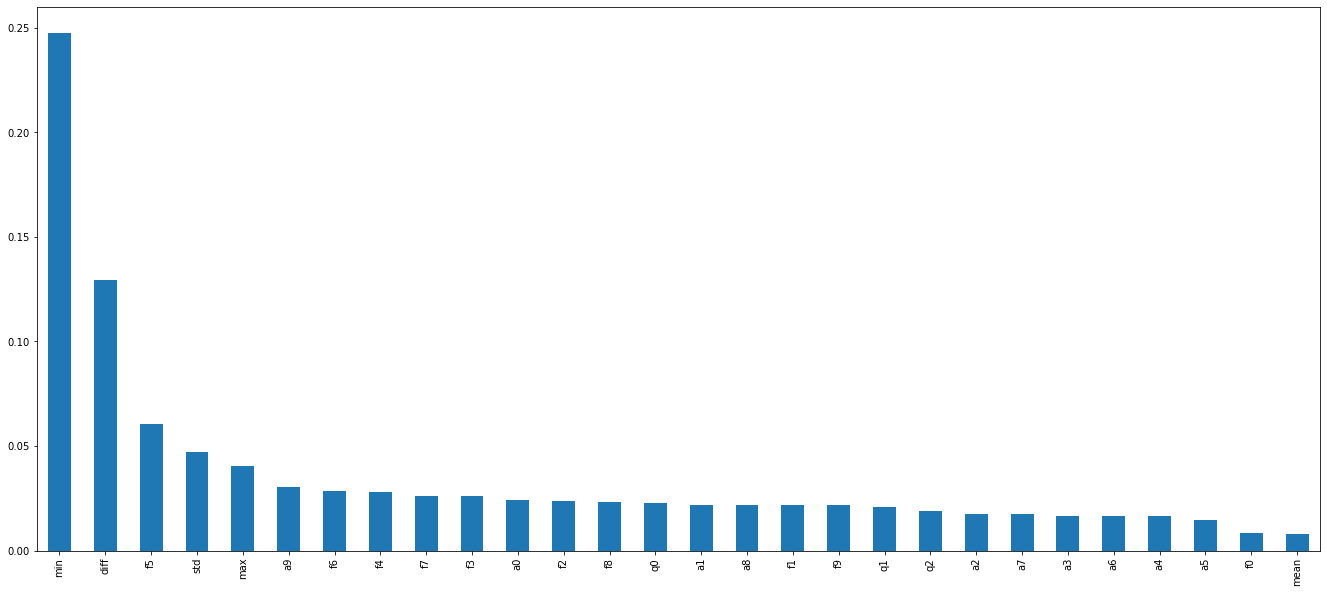

train on chunk is done..
elapsed time (secs) = 1223.325755596161
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.1317400072453499
============ Mean absolute error(in Watts): 32.06619938567094
============ Recall: 0.9554298116425083
============ Precision: 0.550685788321494
============ Accuracy: 0.6308333333333334
============ F1 Score: 0.698673619771001
********************
[DRF-microwave]
********************


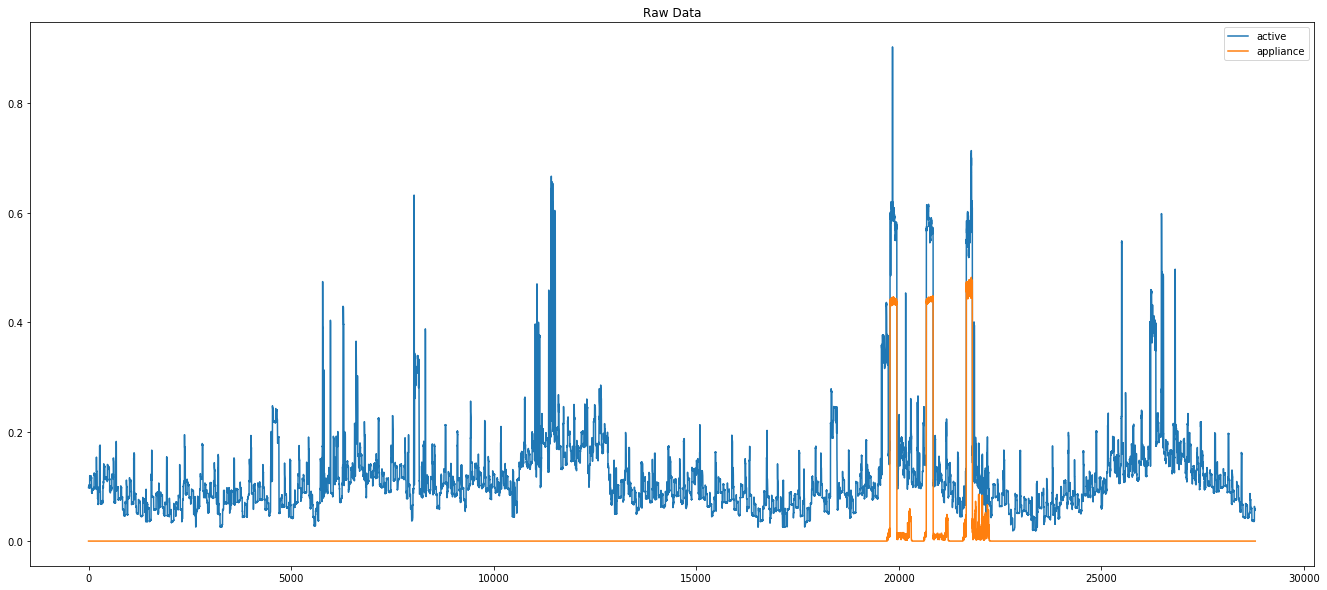

feature selection is done..
model fit is done..
min     0.864632
q0      0.037826
a9      0.036150
f5      0.021284
a0      0.005612
diff    0.005503
f3      0.004201
std     0.003458
max     0.003099
f7      0.002862
a8      0.001962
a1      0.001602
f9      0.001167
a6      0.001153
f1      0.001018
a4      0.000936
f6      0.000891
q2      0.000842
a3      0.000802
mean    0.000788
f4      0.000785
a2      0.000594
f8      0.000543
a7      0.000542
f0      0.000473
f2      0.000445
q1      0.000424
a5      0.000405
dtype: float64


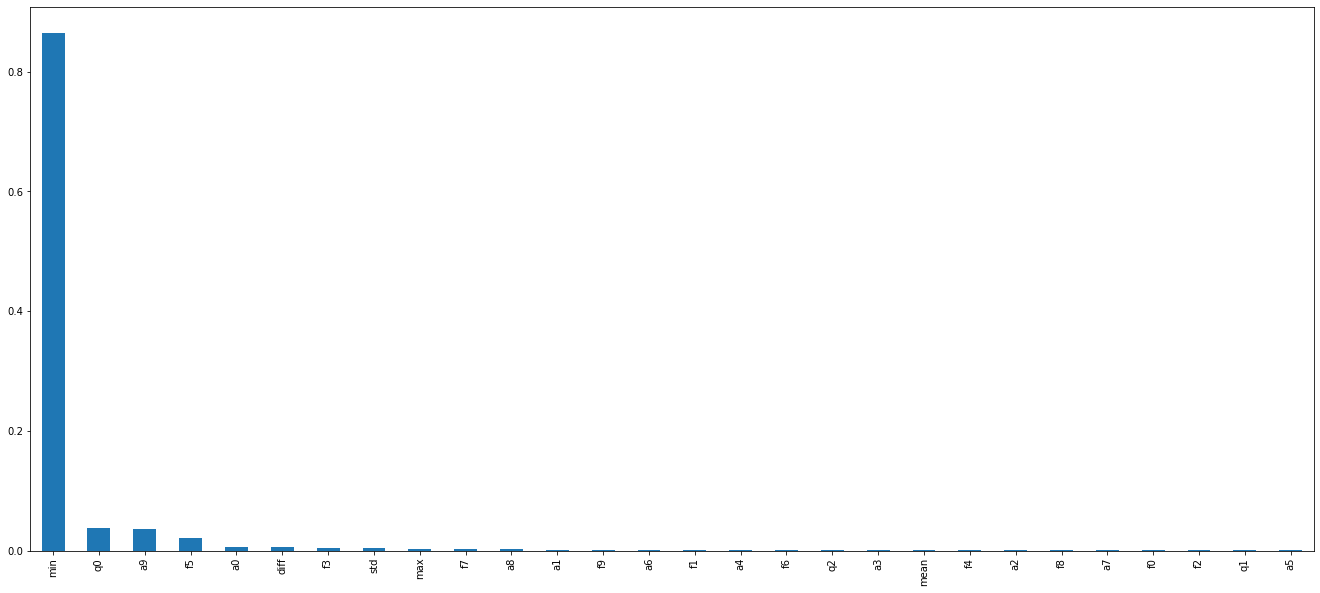

train on chunk is done..
elapsed time (secs) = 155.16039562225342
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.031198384215256603
============ Mean absolute error(in Watts): 2.8748113308942846
============ Recall: 0.9294429708222812
============ Precision: 0.8451519536903039
============ Accuracy: 0.9842361111111111
============ F1 Score: 0.8852956038403235
********************
[DRF-microwave]
********************


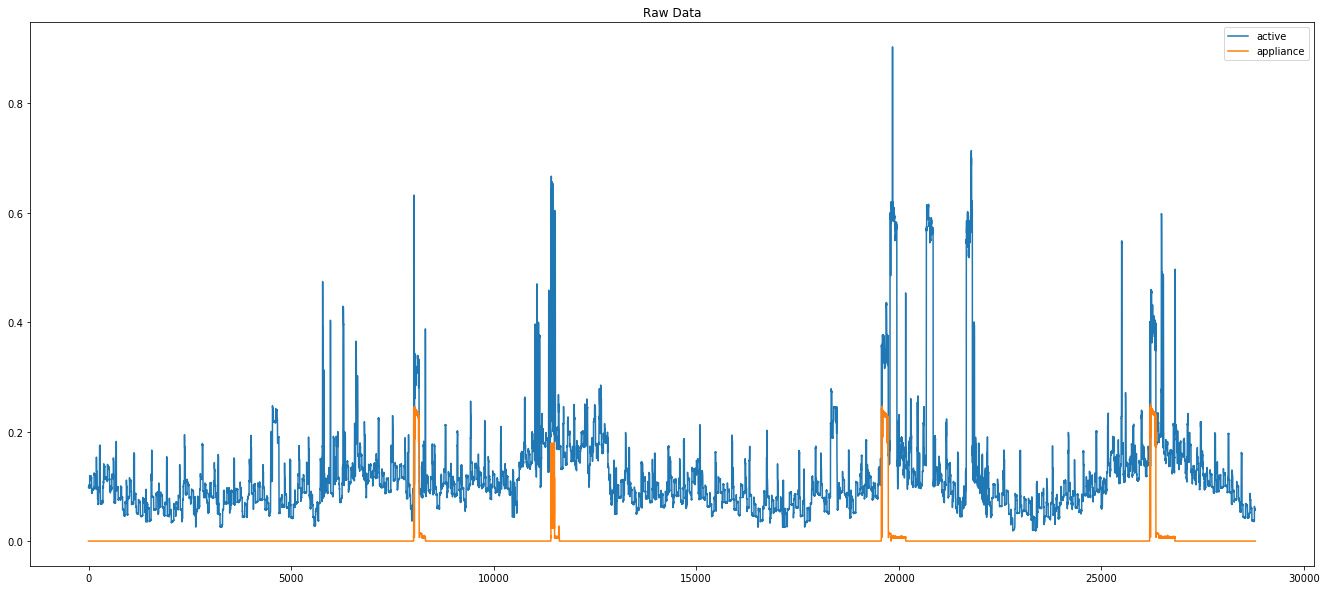

feature selection is done..
model fit is done..
a9      0.458563
max     0.253264
std     0.052380
diff    0.038877
min     0.033858
a0      0.029682
a1      0.023961
a8      0.021934
q1      0.011109
a7      0.009359
q2      0.008693
q0      0.006744
f5      0.006200
f3      0.004933
f6      0.004646
a5      0.004406
a2      0.004137
f4      0.003736
f7      0.003482
f9      0.003049
a6      0.002705
f2      0.002672
f1      0.002493
f8      0.002484
a4      0.002337
a3      0.001850
mean    0.001474
f0      0.000972
dtype: float64


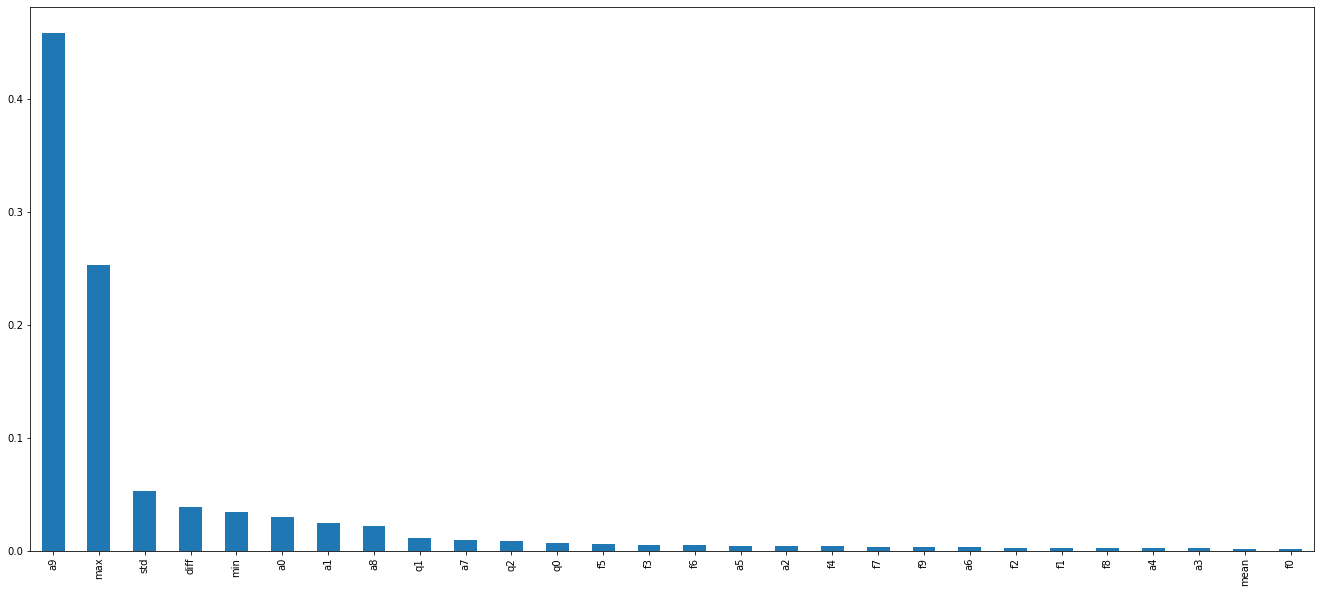

train on chunk is done..
elapsed time (secs) = 135.1984829902649
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.002110951351524648
============ Mean absolute error(in Watts): 1.4887654200218141
============ Recall: 0.9395424836601307
============ Precision: 0.8989056800416884
============ Accuracy: 0.9894097222222222
============ F1 Score: 0.918774966711052
********************
[DRF-microwave]
********************


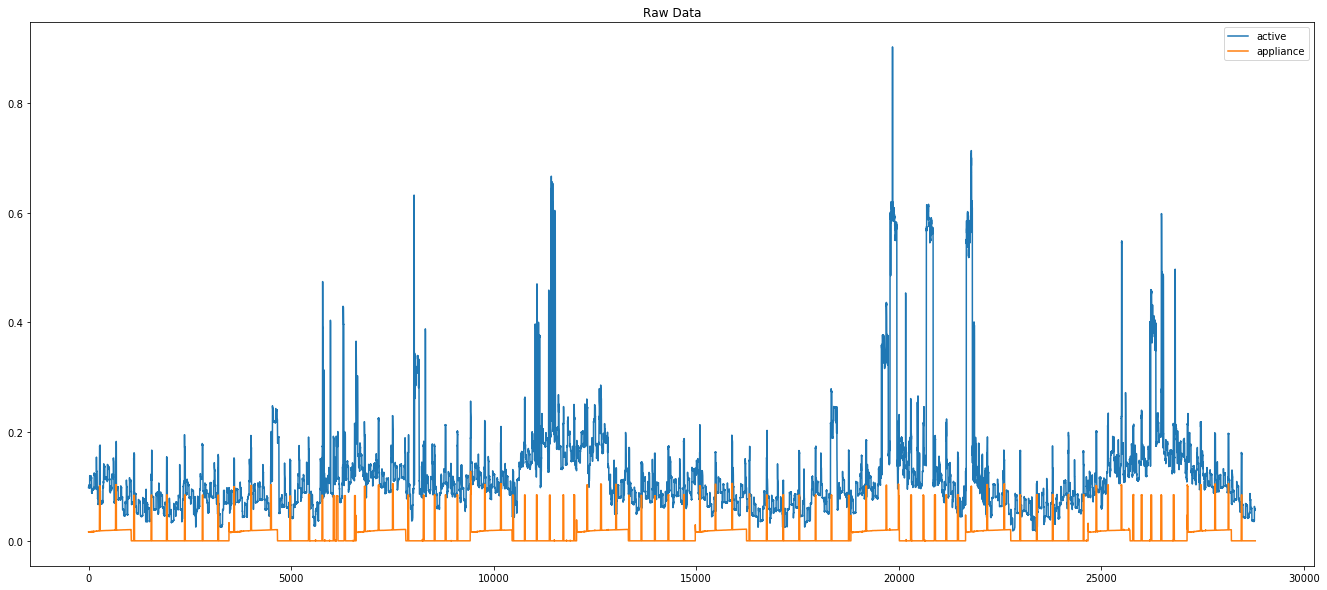

feature selection is done..
model fit is done..
a9      0.224267
diff    0.118366
a0      0.108969
max     0.082237
min     0.078901
std     0.040138
q0      0.034756
q2      0.028757
a8      0.025649
f5      0.024348
a1      0.023647
q1      0.017657
a7      0.015459
a2      0.014620
f6      0.013256
a3      0.012896
f7      0.012554
f4      0.012422
f9      0.012416
a6      0.012291
f3      0.011894
a4      0.011754
f1      0.011692
a5      0.010828
f8      0.010796
f2      0.010578
mean    0.009510
f0      0.009343
dtype: float64


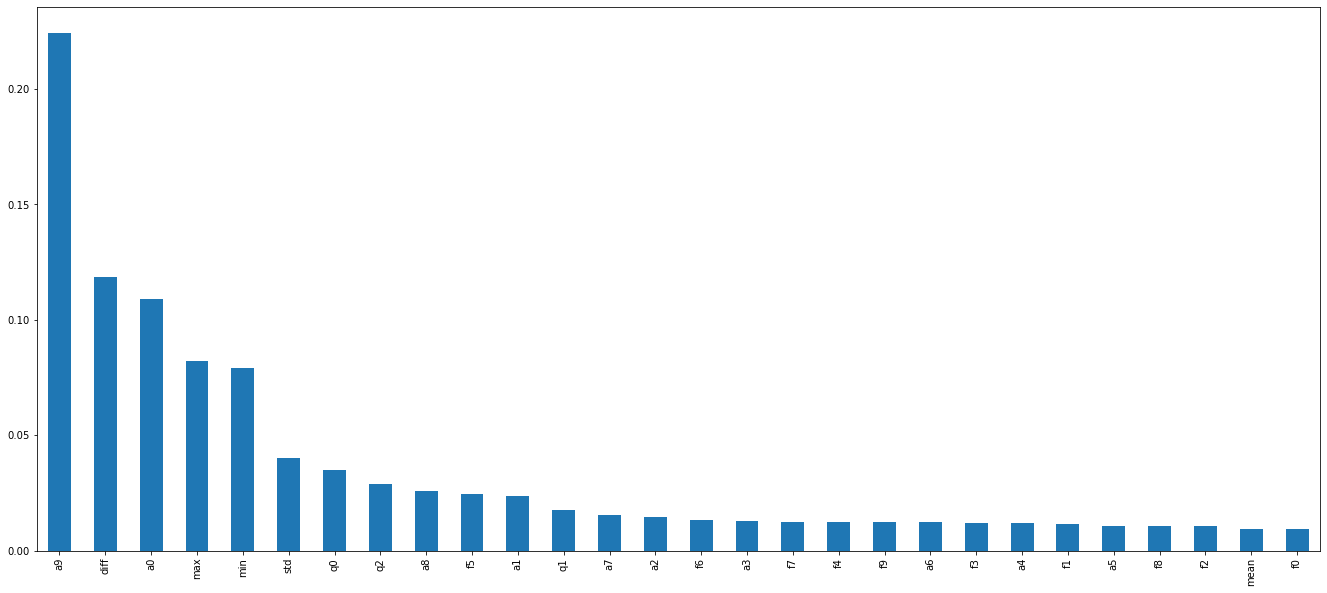

train on chunk is done..
elapsed time (secs) = 95.82630467414856
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.009075871809340634
============ Mean absolute error(in Watts): 10.351069262764126
============ Recall: 0.996921619701634
============ Precision: 0.6670539769726418
============ Accuracy: 0.7797569444444444
============ F1 Score: 0.7992912065310256
********************
[DRF-microwave]
********************


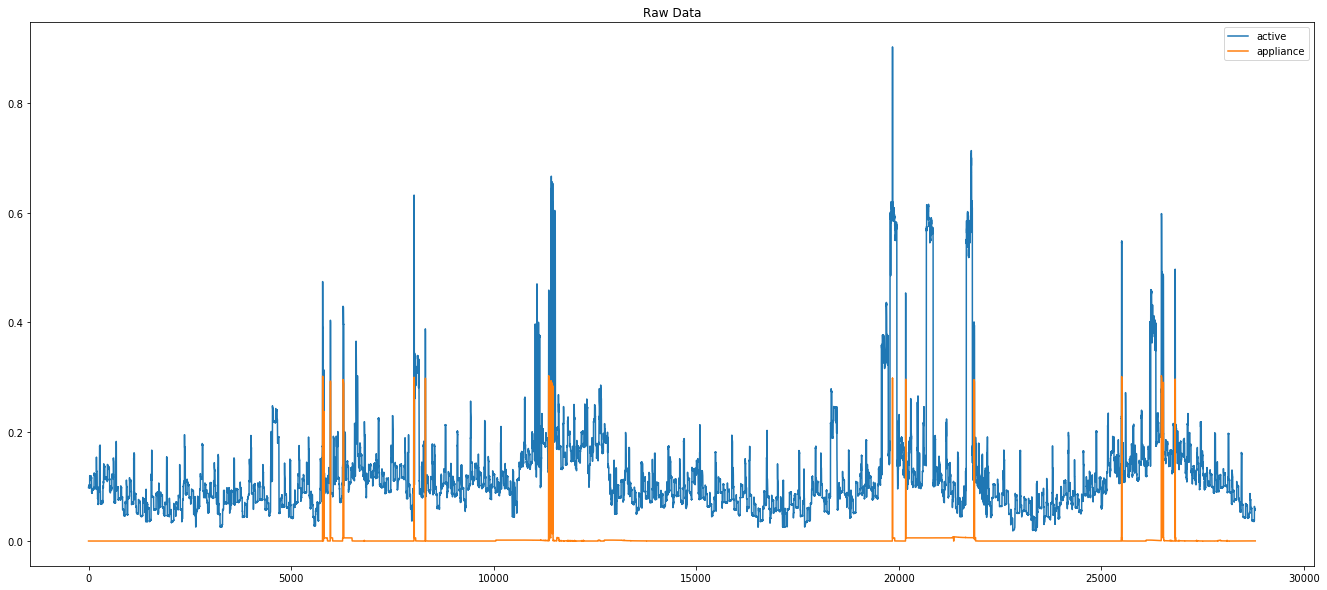

feature selection is done..
model fit is done..
diff    0.346254
a9      0.216989
std     0.062520
f5      0.053276
min     0.037102
max     0.036303
f4      0.021565
q1      0.021084
q0      0.020326
a8      0.019335
a1      0.018120
a7      0.017618
f6      0.016267
a6      0.015917
f2      0.010612
f7      0.010507
q2      0.010108
f3      0.009416
a0      0.008946
f9      0.007660
f1      0.007651
f8      0.006162
mean    0.005251
a3      0.004812
a4      0.004545
f0      0.004201
a2      0.004111
a5      0.003341
dtype: float64


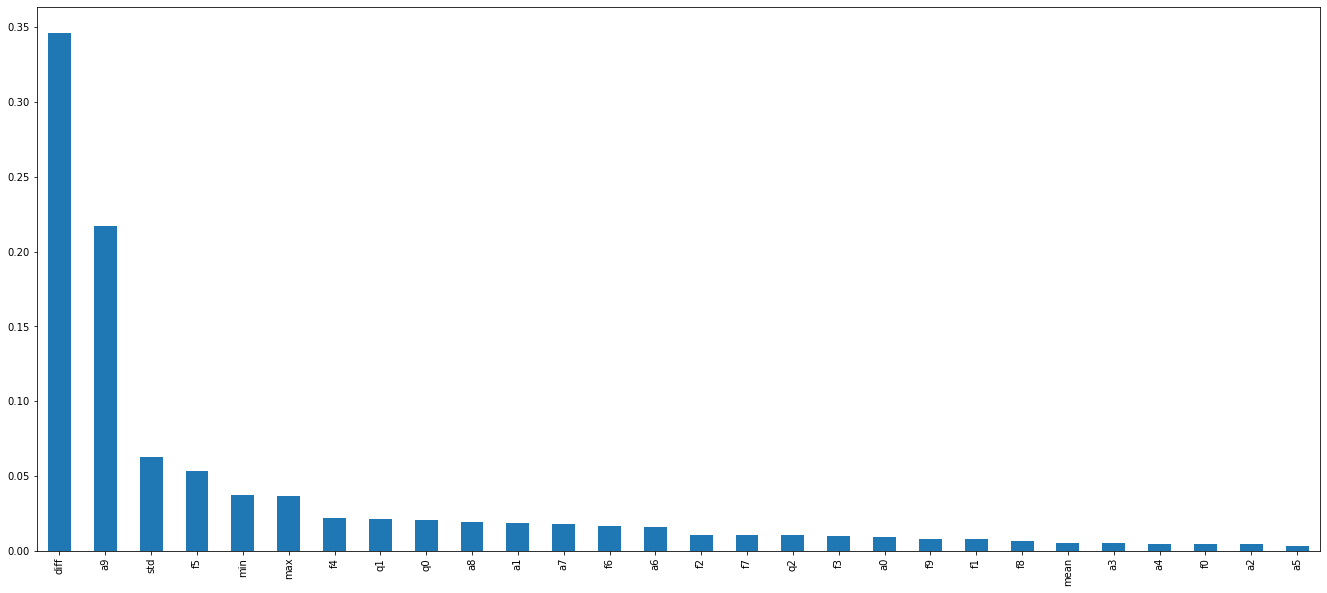

train on chunk is done..
elapsed time (secs) = 137.00310897827148
New sensible chunk: 28800
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.0032547894746197234
============ Mean absolute error(in Watts): 1.849580104794898
============ Recall: 0.9506314580941446
============ Precision: 0.9362985299660761
============ Accuracy: 0.9896527777777778
============ F1 Score: 0.9434105582985188


In [9]:
T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-23'

dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

result2 = []

models = {}
models['DRF'] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]   

    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            pred = disaggregate(dataset, model, aname, P_S, P_E, True)
            result2.append(pred)
        
        except Exception as e:
            print('train & test error', e)

## Concurrent Occurrences (multi-label classification)

- Description
  The issue is whether the proposed method could produce models that could detect multiple appliances operating at the same time. According 
  to the model architecture, each NILM model can only identify a single appliance at a time, so it was hypothesized that building a model 
  for each appliance would enable multi-label classification.

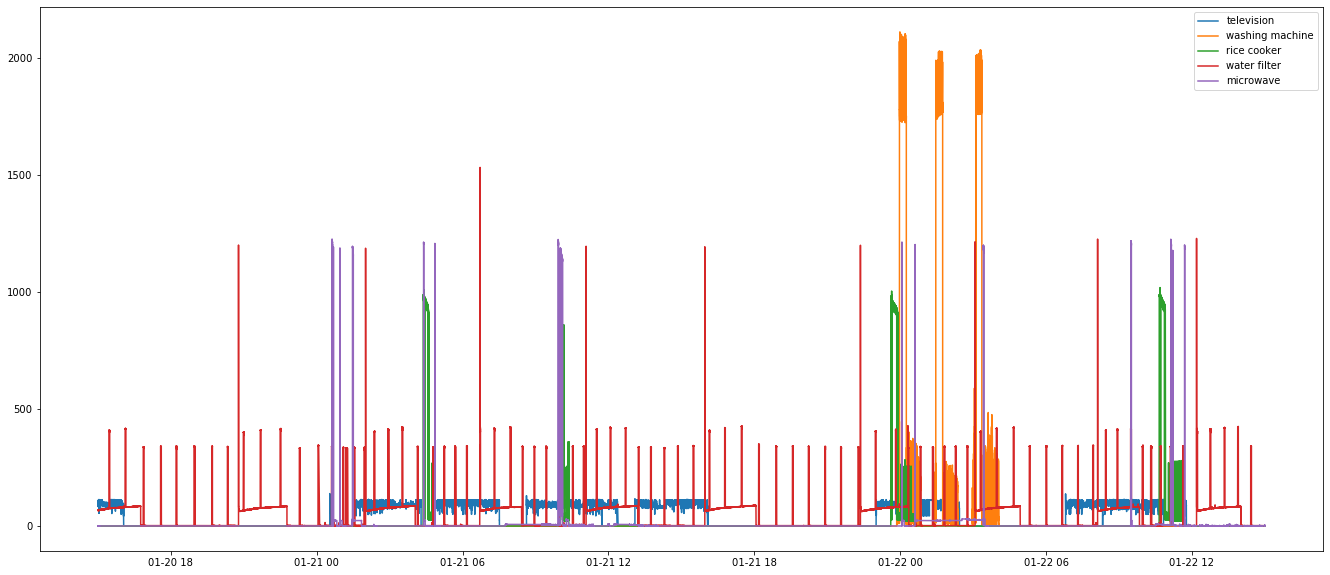

In [13]:
T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-23'

# ground truth graph
dataset = DataSet(DATA_FILE)
dataset.set_window(start=P_S, end=P_E)

test_elec = dataset.buildings[HOME_ID].elec    
test_meter1 = test_elec['television'].power_series_all_data()
test_meter2 = test_elec['washing machine'].power_series_all_data()
test_meter3 = test_elec['rice cooker'].power_series_all_data()
test_meter4 = test_elec['water filter'].power_series_all_data()
test_meter5 = test_elec['microwave'].power_series_all_data()

plt.plot(test_meter1)
plt.plot(test_meter2)
plt.plot(test_meter3)
plt.plot(test_meter4)
plt.plot(test_meter5)
plt.legend(['television', 'washing machine', 'rice cooker', 'water filter', 'microwave'])    
plt.show()

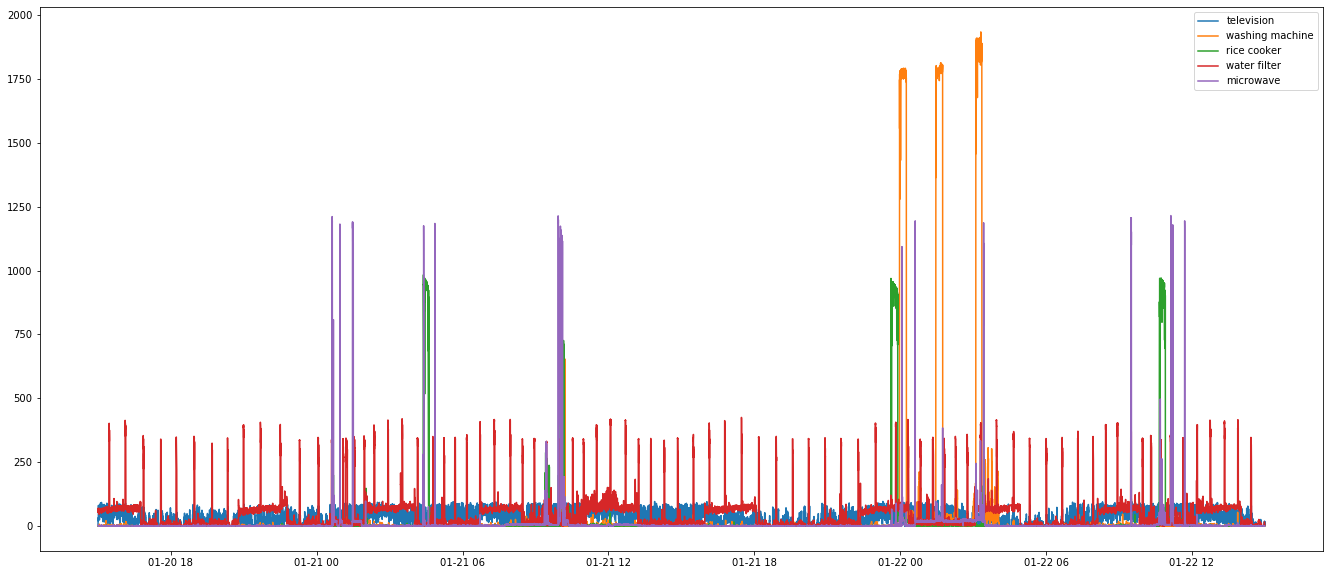

In [12]:
for i in range(len(result)):
    plt.plot(result[i].power_series_all_data())
    
plt.legend(['television', 'washing machine', 'rice cooker', 'water filter', 'microwave'])    
plt.show()  

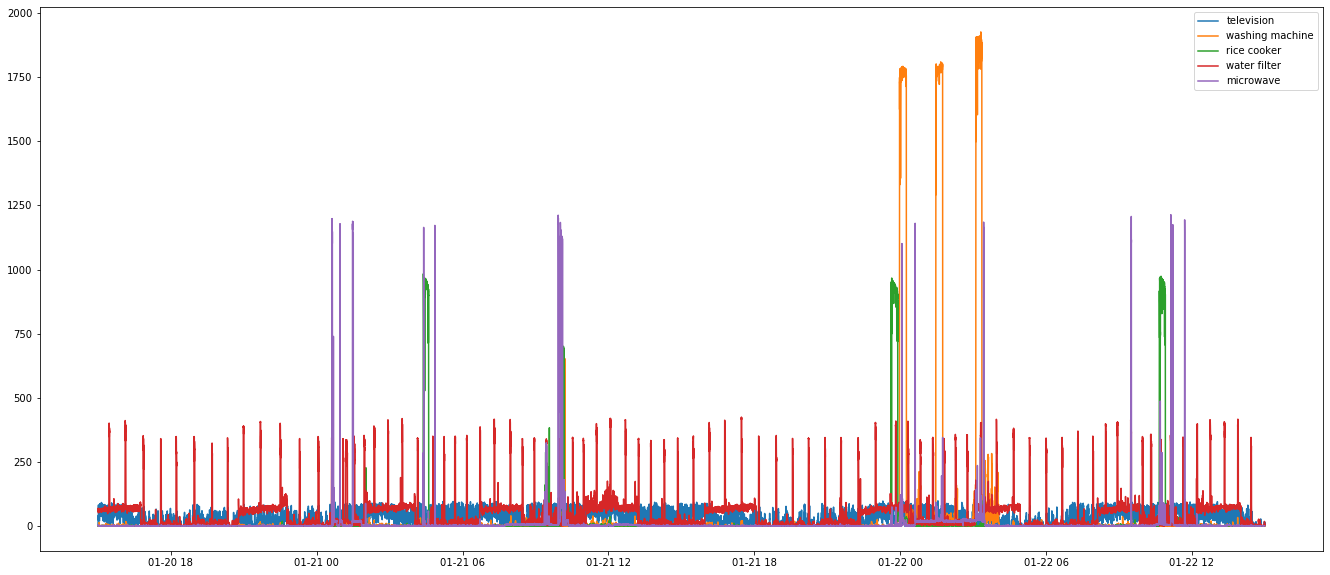

In [10]:
for i in range(len(result2)):
    plt.plot(result2[i].power_series_all_data())
    
plt.legend(['television', 'washing machine', 'rice cooker', 'water filter', 'microwave'])    
plt.show() 